   Knee Angle Left Min (Degrees)  Knee Angle Left Max (Degrees)  \
0                      11.785222                      30.174667   
1                      11.512783                      24.485229   
2                       8.568933                      31.289067   
3                      11.357429                      34.775364   
4                       5.311477                      15.543750   

   Knee Angle Right Min (Degrees)  Knee Angle Right Max (Degrees)  \
0                        3.297120                       12.793680   
1                        8.971800                       22.190800   
2                       11.001778                       27.315528   
3                        9.809327                       27.323462   
4                        6.366708                       14.338348   

   Torso Min (Degrees)  Torso Max (Degrees)  Stride length  Knee L Range  \
0            -1.717352            -0.568045      10.924560     18.389445   
1            -0.054308        

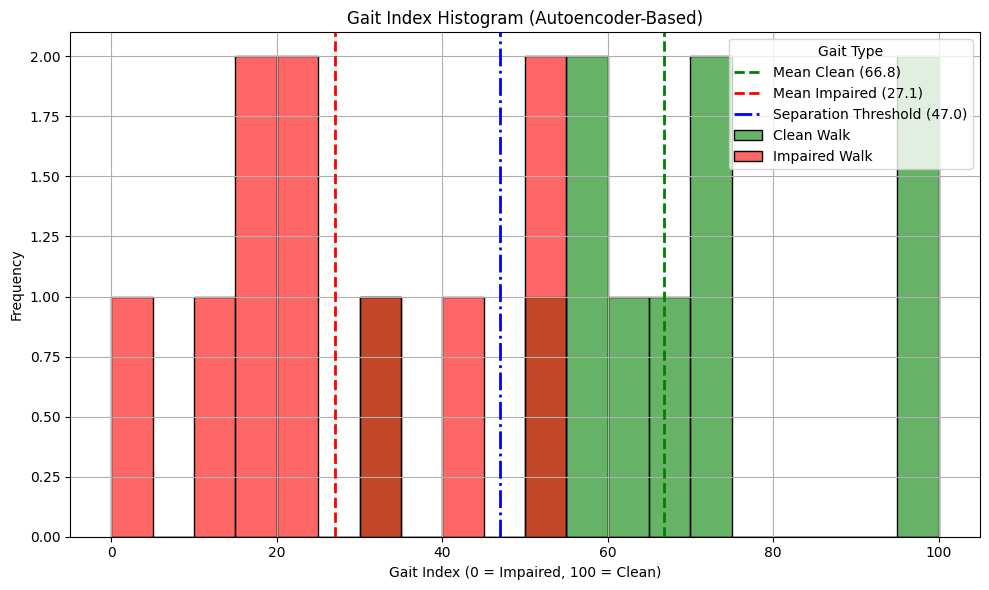

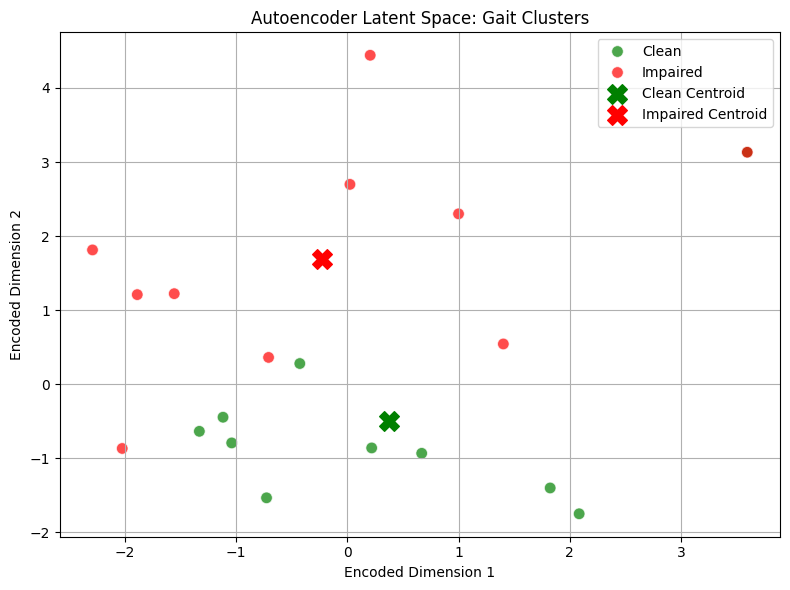

Mean Clean: 66.83
Mean Impaired: 27.08
Suggested Threshold: 46.95
T-test: t = 4.80, p = 0.00014
[[ 0.1584895   0.71229753 -1.76904929 -0.9657878  -0.57245174 -0.54419834
  -0.3066396   0.94316133  0.13930078]
 [ 0.10199486  0.08360847 -0.06240305  0.71797551 -0.13779313 -0.06745693
   1.22762652  0.04395138  1.19304823]
 [-0.50845901  0.83543996  0.54810785  1.6362173   0.20465774  0.21250628
   0.84840419  1.66204634  2.06910931]
 [ 0.06977973  1.22067959  0.18948115  1.6376389   0.22128224  0.19058024
   1.60121091  1.77787989  2.40891395]
 [-1.18394416 -0.90443478 -0.84587805 -0.68901629 -0.75055278 -0.80666895
   0.33175117 -0.41091157 -0.29237336]
 [-1.36530793 -1.11526334 -1.07739604 -0.68385413 -0.76487477 -0.78218968
   0.55308241 -0.58244114 -0.06630063]
 [-0.2992525  -0.23440587  0.44766054 -0.14138066 -1.00212798 -1.00651469
  -0.15188478 -0.11257731 -0.64472584]
 [-0.86286969 -0.45228087 -1.00711991 -0.78447843 -1.2014515  -1.06034355
   0.5715612   0.01130431 -0.29142205]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import mse

# Setting seeds for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'



#Load & Preprocess Data
file_path = 'CompressedGaitVisionMain.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')
df['Knee L Range'] = df['Knee Angle Left Max (Degrees)'] - df['Knee Angle Left Min (Degrees)']
df['Knee R Range'] = df['Knee Angle Right Max (Degrees)'] - df['Knee Angle Right Min (Degrees)']


labels = df['Type']
features = df.drop(columns=['Type'])


# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(features.head())
# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#Autoencoder
input_dim = features_scaled.shape[1]
encoding_dim = 2

# Encoder
input_layer = Input(shape=(input_dim,))
x = Dense(32, activation='relu', kernel_regularizer=l2(1e-4))(input_layer)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu', kernel_regularizer=l2(1e-4))(x)
encoded = Dense(encoding_dim, activation='linear')(x)

# Decoder
x = Dense(16, activation='relu')(encoded)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
decoded = Dense(input_dim, activation='linear')(x)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')

# Train
history = autoencoder.fit(features_scaled, features_scaled,
                          epochs=300,
                          batch_size=4,
                          verbose=0)


#Get Encoded Data

encoded_data = encoder.predict(features_scaled)
encoded_df = pd.DataFrame(encoded_data, columns=["Dim1", "Dim2"])
encoded_df['Type'] = labels.values
print(encoded_data)

#Gait Index Calculation
clean_centroid = encoded_df[encoded_df['Type'] == 'Clean'][['Dim1', 'Dim2']].mean().values
impaired_centroid = encoded_df[encoded_df['Type'] == 'Impaired'][['Dim1', 'Dim2']].mean().values

dist_to_clean = np.linalg.norm(encoded_data - clean_centroid, axis=1)
dist_to_impaired = np.linalg.norm(encoded_data - impaired_centroid, axis=1)

#higher Gait Index = closer to Clean
gait_index_clean = 1 - (dist_to_clean / (dist_to_clean + dist_to_impaired))
gait_index_scaled = MinMaxScaler(feature_range=(0, 100)).fit_transform(gait_index_clean.reshape(-1, 1)).flatten()

encoded_df['Gait_Index_Scaled'] = gait_index_scaled

#Statistical Analysis
clean_vals = encoded_df[encoded_df['Type'] == 'Clean']['Gait_Index_Scaled']
impaired_vals = encoded_df[encoded_df['Type'] == 'Impaired']['Gait_Index_Scaled']

mean_clean = clean_vals.mean()
mean_impaired = impaired_vals.mean()
threshold = (mean_clean + mean_impaired) / 2

t_stat, p_val = ttest_ind(clean_vals, impaired_vals)

#Plots
plt.figure(figsize=(10, 6))
bins = range(0, 101, 5)

sns.histplot(clean_vals, bins=bins, color='green', label='Clean Walk', alpha=0.6)
sns.histplot(impaired_vals, bins=bins, color='red', label='Impaired Walk', alpha=0.6)

plt.axvline(mean_clean, color='green', linestyle='--', linewidth=2, label=f'Mean Clean ({mean_clean:.1f})')
plt.axvline(mean_impaired, color='red', linestyle='--', linewidth=2, label=f'Mean Impaired ({mean_impaired:.1f})')
plt.axvline(threshold, color='blue', linestyle='-.', linewidth=2, label=f'Separation Threshold ({threshold:.1f})')

plt.title('Gait Index Histogram (Autoencoder-Based)')
plt.xlabel('Gait Index (0 = Impaired, 100 = Clean)')
plt.ylabel('Frequency')
plt.legend(title='Gait Type')
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
sns.scatterplot(data=encoded_df, x='Dim1', y='Dim2', hue='Type', palette=['green', 'red'], alpha=0.7, s=70)

# Mark centroids
plt.scatter(*clean_centroid, color='green', marker='X', s=200, label='Clean Centroid')
plt.scatter(*impaired_centroid, color='red', marker='X', s=200, label='Impaired Centroid')

plt.title('Autoencoder Latent Space: Gait Clusters')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Print Stats
print(f"Mean Clean: {mean_clean:.2f}")
print(f"Mean Impaired: {mean_impaired:.2f}")
print(f"Suggested Threshold: {threshold:.2f}")
print(f"T-test: t = {t_stat:.2f}, p = {p_val:.5f}")

print(features_scaled)


In [ ]:
output_path = 'GaitIndex_Results.xlsx'
encoded_df.to_excel(output_path, index=False)
print(f"Gait Index scores saved to: {output_path}")
print(encoder)
# Save the encoder
converter = tf.lite.TFLiteConverter.from_keras_model(encoder)
tflite_model = converter.convert()
with open('encoder_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Save scaler params manually
np.save("scaler_mean.npy", scaler.mean_.astype(np.float32))
np.save("scaler_scale.npy", scaler.scale_.astype(np.float32))
print("scalerMean: %s" % scaler.mean_)
print("ScalerScale: %s" % scaler.scale_)
print("CleanCentroid: %s" % clean_centroid)
print("ImpairedCentroid: %s" % impaired_centroid)
np.save("clean_centroid.npy", clean_centroid)
np.save("impaired_centroid.npy", impaired_centroid)

np.load("scaler_mean.npy").astype('float32').tofile("scaler_mean.bin")
np.load("scaler_scale.npy").astype('float32').tofile("scaler_scale.bin")


Gait Index scores saved to: GaitIndex_Results.xlsx
<Functional name=functional_1, built=True>
Saved artifact at '/tmp/tmp58c57cpq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 9), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132840657347472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132840657348048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132840657350544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132840657345168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132840657350160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132840657350352: TensorSpec(shape=(), dtype=tf.resource, name=None)
scalerMean: [11.02092317 23.72859905  9.17929311 18.18376288  0.47290164  1.81684352
 11.55900382 12.70767588  9.00446977]
ScalerScale: [4.82239461 9.04968403 3.32504761 5.58102198 3.82609313 4.38238887
 2.069021

In [ ]:
from math import dist
features = pd.DataFrame([{
    'Knee Angle Left Min (Degrees)': 11.7852220888889,
    'Knee Angle Left Max (Degrees)': 30.1746666666667,
    'Knee Angle Right Min (Degrees)': 3.2971200068,
    'Knee Angle Right Max (Degrees)': 12.793679964,
    'Torso Min (Degrees)': -1.71735203785714,
    'Torso Max (Degrees)': -0.568045216940909,
    'Stride length': 10.92456

    # ... all other required feature columns
    }])
    # Load models and scalers
encoder = load_model("encoder_model.h5")
scaler = joblib.load("scaler.save")
clean_centroid = np.load("clean_centroid.npy")
impaired_centroid = np.load("impaired_centroid.npy")

    # Feature Engineering (must match training)
features['Knee L Range'] = features['Knee Angle Left Max (Degrees)'] - features['Knee Angle Left Min (Degrees)']
features['Knee R Range'] = features['Knee Angle Right Max (Degrees)'] - features['Knee Angle Right Min (Degrees)']

    # Ensure the same feature columns are used
feature_columns = [col for col in features.columns if col != 'Type']
features_new = features[feature_columns]

    # Scale features
scaled = scaler.transform(features_new)

    # Encode
encoded = encoder.predict(scaled)

    # Distance to centroids
dist_clean = np.linalg.norm(encoded - clean_centroid)
dist_impaired = np.linalg.norm(encoded - impaired_centroid)
print(dist_clean)
print(dist_impaired)

    # Gait index (unscaled)
gait_index_clean = 1 - (dist_clean / (dist_clean + dist_impaired))
print(f"Gait Index (Unscaled): {gait_index_clean:.2f}")

    # Scale to 0-100
gait_index_scaled = gait_index_clean * 100

print(f"Gait Index (Scaled): {gait_index_scaled:.2f}")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'encoder_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
import numpy as np
import os
import sys


def inspect_npy_file(filepath):
    arr = np.load(filepath)
    byte_size = os.path.getsize(filepath)
    num_floats = arr.size
    endianness = arr.dtype.byteorder
    # Interpret the byteorder symbol
    if endianness == '=':
        endianness_str = 'Native'
    elif endianness == '<':
        endianness_str = 'Little-endian'
    elif endianness == '>':
        endianness_str = 'Big-endian'
    else:
        endianness_str = 'Unknown'

    print(f"{filepath}:")
    print(f"  Shape: {arr.shape}")
    print(f"  Dtype: {arr.dtype}")
    print(f"  Endianness: {endianness_str}")
    print(f"  Num Floats: {num_floats}")
    print(f"  Byte Size: {byte_size}")
    print(f"  Values: {arr}")
    print(f"Native byte order: {sys.byteorder}")
    print()

# Example usage
inspect_npy_file("scaler_mean.npy")
inspect_npy_file("scaler_scale.npy")
inspect_npy_file("clean_centroid.npy")
inspect_npy_file("impaired_centroid.npy")

scaler_mean.npy:
  Shape: (9,)
  Dtype: float32
  Endianness: Native
  Num Floats: 9
  Byte Size: 164
  Values: [11.020924   23.7286      9.179293   18.183764    0.47290164  1.8168435
 11.559004   12.707676    9.00447   ]
Native byte order: little

scaler_scale.npy:
  Shape: (9,)
  Dtype: float32
  Endianness: Native
  Num Floats: 9
  Byte Size: 164
  Values: [4.8223944 9.049684  3.3250475 5.581022  3.8260932 4.382389  2.0690212
 6.0241747 3.5325732]
Native byte order: little

clean_centroid.npy:
  Shape: (2,)
  Dtype: float32
  Endianness: Native
  Num Floats: 2
  Byte Size: 136
  Values: [ 0.37412527 -0.4953907 ]
Native byte order: little

impaired_centroid.npy:
  Shape: (2,)
  Dtype: float32
  Endianness: Native
  Num Floats: 2
  Byte Size: 136
  Values: [-0.22507378  1.6850245 ]
Native byte order: little

